In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc

# Import TSNE
from sklearn.manifold import TSNE

In [41]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...
1,2016-03-31,2100,2016-04-01,1553,QA,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,MEDUR,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha..."
3,2016-03-25,1400,2016-04-01,2126,QA,C7,MEDMED,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...
4,2016-04-02,0730,2016-04-02,0752,QA,D5,SURMHN,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...


In [42]:
df['division'] = df['inc_unit'].str[:3]
df['care group'] = df['inc_unit'].str[3:6]
df = df.drop('inc_unit',axis=1)

In [43]:
df.columns = [column.replace('inc_organisation','site') for column in df.columns]
df.columns = [column.replace('inc_locactual','ward/dept/unit') for column in df.columns]
df.columns = [column.replace('inc_unit','division & care group') for column in df.columns]
df.columns = [column.replace('inc_specialty','specialty') for column in df.columns]
df.columns = [column.replace('inc_loctype','location type') for column in df.columns]
df.columns = [column.replace('inc_result','result') for column in df.columns]
df.columns = [column.replace('inc_severity','severity') for column in df.columns]
df.columns = [column.replace('inc_reportedby','reported by') for column in df.columns]
df.columns = [column.replace('show_other_contacts','other patients involved?') for column in df.columns]
df.columns = [column.replace('show_employee','other employees involved?') for column in df.columns]
df.columns = [column.replace('show_witness','any witnesses?') for column in df.columns]
df.columns = [column.replace('show_document','any documents attached?') for column in df.columns]
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...,MED,MED
1,2016-03-31,2100,2016-04-01,1553,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha...",MED,UR
3,2016-03-25,1400,2016-04-01,2126,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED
4,2016-04-02,0730,2016-04-02,0752,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN


In [44]:
df['inc_time'] = df['inc_time'].str.replace(':','')
df['inc_submittedtime'] = df['inc_submittedtime'].str.replace(':','')

In [45]:
df['inc_year'] = df.inc_dincident.dt.year
df['inc_month'] = df.inc_dincident.dt.month
df['inc_day'] = df.inc_dincident.dt.day
df['inc_week'] = df.inc_dincident.dt.week
df['inc_weekday'] = df.inc_dincident.dt.weekday
df['inc_quarter'] = df.inc_dincident.dt.quarter
df['inc_hour'] = df['inc_time'].str[:2]
df['inc_minute'] = df['inc_time'].str[2:4]
df['inc_time_datetime'] = pd.to_datetime(df['inc_time'], format='%H%M')
df['inc_time_timedelta'] = pd.to_timedelta(df['inc_time_datetime']) + pd.Timedelta(days=25567)
df['inc_datetime'] = df['inc_dincident'] + df['inc_time_timedelta']
df['inc_date_delta'] = (df['inc_datetime'] - df['inc_datetime'].min())  / np.timedelta64(1,'D')
df['reported_year'] = df.inc_dreported.dt.year
df['reported_month'] = df.inc_dreported.dt.month
df['reported_day'] = df.inc_dreported.dt.day
df['reported_week'] = df.inc_dreported.dt.week
df['reported_weekday'] = df.inc_dreported.dt.weekday
df['reported_quarter'] = df.inc_dincident.dt.quarter
df['reported_hour'] = df['inc_submittedtime'].str[:2]
df['reported_minute'] = df['inc_submittedtime'].str[2:4]
df['reported_time_datetime'] = pd.to_datetime(df['inc_submittedtime'], format='%H%M')
df['reported_time_timedelta'] = pd.to_timedelta(df['reported_time_datetime']) + pd.Timedelta(days=25567)
df['reported_datetime'] = df['inc_dreported'] + df['reported_time_timedelta']
df['reported_date_delta'] = (df['reported_datetime'] - df['reported_datetime'].min())  / np.timedelta64(1,'D')
df['diff'] = df['reported_datetime'] - df['inc_datetime']
df['reported-incident'] = df['diff'] / np.timedelta64(1, 'D')
df = df.astype({'inc_hour':'int'})
df = df.astype({'inc_minute':'int'})
df = df.astype({'reported_hour':'int'})
df = df.astype({'reported_minute':'int'})
df = df.drop(['inc_dincident','inc_time','inc_dreported','inc_submittedtime','inc_time_datetime','inc_time_timedelta','inc_datetime','reported_time_datetime','reported_time_timedelta','reported_datetime','diff'],axis=1)
print(df.columns)
df = df.drop(['inc_year', 'inc_month', 'inc_day',
       'inc_week', 'inc_quarter', 'inc_minute',
       'reported_year', 'reported_month', 'reported_day',
       'reported_week', 'reported_weekday', 'reported_quarter',
       'reported_hour', 'reported_minute', 'reported_date_delta',
       'reported-incident'],axis=1)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version


Index(['site', 'ward/dept/unit', 'specialty', 'location type', 'result',
       'severity', 'other patients involved?', 'other employees involved?',
       'any witnesses?', 'any documents attached?', 'reported by', 'inc_notes',
       'division', 'care group', 'inc_year', 'inc_month', 'inc_day',
       'inc_week', 'inc_weekday', 'inc_quarter', 'inc_hour', 'inc_minute',
       'inc_date_delta', 'reported_year', 'reported_month', 'reported_day',
       'reported_week', 'reported_weekday', 'reported_quarter',
       'reported_hour', 'reported_minute', 'reported_date_delta',
       'reported-incident'],
      dtype='object')


,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group,inc_weekday,inc_hour,inc_date_delta
0,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...,MED,MED,3,8,397.895833
1,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED,3,21,398.437500
2,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha...",MED,UR,4,19,399.393750
3,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED,4,14,392.145833
4,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN,5,7,399.875000


In [46]:
result_classes = [str(i) for i in df['result'].value_counts().index]
result_mapping = {'NMISS':0,'NOHARM':1,'HARM':2}
df_replaced = df.replace({'result': result_mapping})

severity_classes = [str(i) for i in df['severity'].value_counts().index]
severity_mapping = {'NMISS':0,'NONE':1,'LOW':2,'MODRTE':3,'SEVERE':4,'':None}
df_replaced = df_replaced.replace({'severity': severity_mapping})

binary_mapping = {'N':0,'Y':1}
df_replaced = df_replaced.replace({'other patients involved?': binary_mapping})
df_replaced = df_replaced.replace({'other employees involved?': binary_mapping})
df_replaced = df_replaced.replace({'any witnesses?': binary_mapping})
df_replaced = df_replaced.replace({'any documents attached?': binary_mapping})
df_replaced.head()

,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group,inc_weekday,inc_hour,inc_date_delta
0,QA,E6/7,RESP,WARD,1,1.0,NaN,0,0,0,None,on drug rounds found Amlodipine not given for ...,MED,MED,3,8,397.895833
1,QA,C5,GENMED,WARD,2,2.0,NaN,1,1,1,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED,3,21,398.437500
2,QA,EMERG,ED,AE,1,1.0,NaN,0,0,0,Other,"Resus controlled order booked went missing, ha...",MED,UR,4,19,399.393750
3,QA,C7,CARDIO,WARD,1,1.0,NaN,1,0,0,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED,4,14,392.145833
4,QA,D5,ORTHO,WARD,1,1.0,NaN,0,0,0,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN,5,7,399.875000


In [47]:
df_dropped = df_replaced.dropna()
df_dropped.head()

,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group,inc_weekday,inc_hour,inc_date_delta
815,QA,EMERG,ED,AE,1,1.0,0.0,0,0,0,,"MH patient on side room in Obs ward, ED. Bipol...",MED,UR,6,23,562.541667
816,QA,PHARQA,PHARM,PHAR,0,0.0,0.0,0,1,0,,patient undergoing outpatient detox with ASNS....,CLI,PHA,6,10,561.979167
817,QA,G1,ACUTE,WARD,1,1.0,0.0,1,0,0,,Clexane was not given. Drug chart stated that ...,MED,OLD,3,22,559.479167
818,QA,PHARQA,PHARM,PHAR,1,1.0,0.0,0,0,0,,F7 ward ordered midazolam injection 5mg/ml (10...,CLI,PHA,6,11,562.020833
819,QA,SAU,GENSUR,WARD,1,1.0,0.0,0,0,0,,Patient discharged from hospital no referral t...,SUR,SUR,6,13,562.104167


In [48]:
df_num = df_dropped.select_dtypes(np.number)
print(df_num.columns)
df_num.head()

Index(['result', 'severity', 'other patients involved?',
       'other employees involved?', 'any witnesses?',
       'any documents attached?', 'inc_weekday', 'inc_hour', 'inc_date_delta'],
      dtype='object')


,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,inc_weekday,inc_hour,inc_date_delta
815,1,1.0,0.0,0,0,0,6,23,562.541667
816,0,0.0,0.0,0,1,0,6,10,561.979167
817,1,1.0,0.0,1,0,0,3,22,559.479167
818,1,1.0,0.0,0,0,0,6,11,562.020833
819,1,1.0,0.0,0,0,0,6,13,562.104167


In [49]:
# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(df_num)

In [50]:
# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

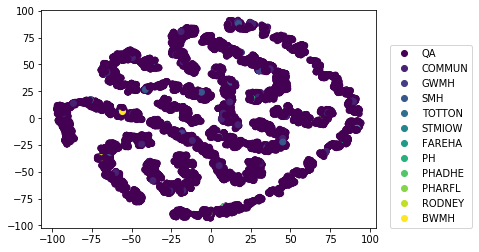

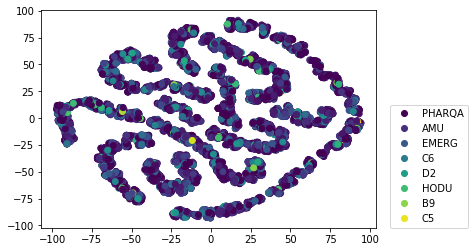

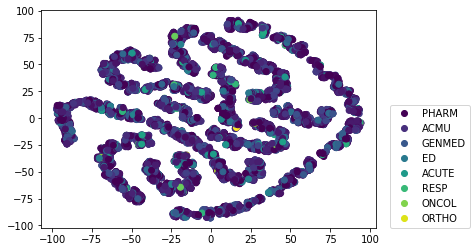

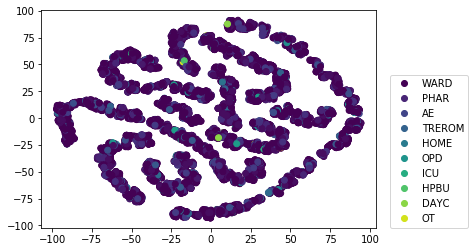

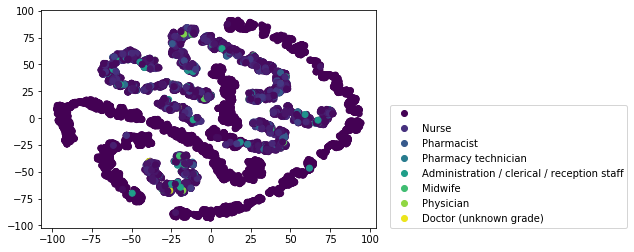

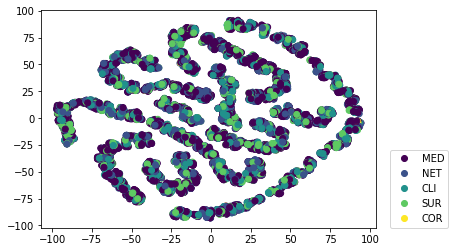

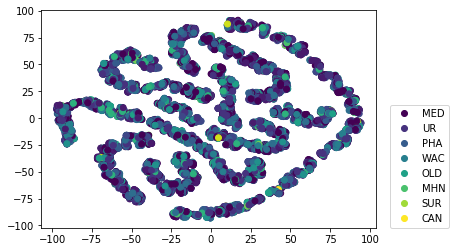

In [51]:
category_columns = list(df_replaced.select_dtypes('object'))
category_columns.remove('inc_notes')
for column in category_columns:
    classes = [str(i) for i in df_dropped[column].value_counts().index]
    mapping = dict((el,i) for i,el in enumerate(classes))
    df_mapped = df_dropped.replace({column: mapping})
    
    fig, ax = plt.subplots()
    
    # Scatter plot, coloring by column
    scatter = ax.scatter(xs,ys,c=df_mapped[column].values,label=classes)

    # produce a legend with a cross section of sizes from the scatter
    handles, labels = scatter.legend_elements(prop="colors")
    legend2 = ax.legend(handles, mapping.keys(), loc=(1.04,0))